## Caso de Negocio

Una empresa de distribución de bebidas enfrenta una necesidad de optimizar su planificación financiera y evaluar el desempeño de cada tienda. Actualmente, la falta de visibilidad sobre los ingresos mensuales limita la capacidad de la empresa para tomar decisiones informadas sobre inversiones, promociones y estrategias de ventas. Por ello, se busca implementar un modelo de pronóstico que analice los ingresos mensuales por tienda, utilizando datos históricos de ventas. Este enfoque permitirá anticipar posibles fluctuaciones  y establecer metas más realistas para cada tienda, facilitando una asignación más efectiva de recursos.

### Preparación de Ambiente

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates


### Cargar Dataframe

In [ ]:
df = pd.read_csv('/Ventas_Bebidas_Demo.csv', encoding='latin-1')
df.columns = df.columns.str.lower()

In [ ]:
print('Tamaño del dataset: ',df.shape)

Tamaño del dataset:  (52672, 15)


In [ ]:
df.head(2)

,pedido,tienda,fecha,sabor,marca,segmento,segmento_desc,municipio,producto,producto_desc,unidades,monto,prom_temperatura,precio_unidad,contador
0,1000244507,1000043345,06-07-13,MANZANA,DEL VALLE,110,EXTRA GRANDE BAJO AUDITABLE,GUADALUPE,9322,JDV Manz Nec 100 m,24,48.0,31.9,2.0,1
1,1000242608,1000043345,02-07-13,MANGO,DEL VALLE,110,EXTRA GRANDE BAJO AUDITABLE,GUADALUPE,9321,JDV Mango Nec 100,24,48.0,26.5,2.0,1


### Limpieza y Transformación de Datos

In [ ]:
df['monto_total'] = df['unidades']*df['monto']

df['fecha'] = pd.to_datetime(df['fecha'],format='%d-%m-%y')
df['fecha'] = df['fecha'].dt.strftime('%Y-%m-01')

In [ ]:
dicc = {
    1000043345: 'Tienda 1',
    1000050643: 'Tienda 2',
    1000038155: 'Tienda 3',
    1000005887: 'Tienda 4',
    1000007403: 'Tienda 5',
    1000071011: 'Tienda 6'
}
df['tienda'] = df['tienda'].replace(dicc)

In [ ]:
final_df = df.groupby(['tienda','fecha']).agg({
    'monto_total':'sum'
}
).sort_values(by=['tienda','fecha']).reset_index()

In [ ]:
final_df

,tienda,fecha,monto_total
0,Tienda 1,2012-01-01,1610631.67
1,Tienda 1,2012-02-01,1591641.93
2,Tienda 1,2012-03-01,2533074.03
3,Tienda 1,2012-04-01,2738859.82
4,Tienda 1,2012-05-01,2879172.03
...,...,...,...
175,Tienda 6,2014-02-01,537247.74
176,Tienda 6,2014-03-01,291373.56
177,Tienda 6,2014-04-01,256601.44
178,Tienda 6,2014-05-01,432256.94


## ``ARIMA``


### Functions

In [ ]:
def plot_acf_q(store):
    plot_acf(store['monto_total'])
    plt.title('ACF Plot')
    plt.show()

def plot_pacf_p(store):
    plot_pacf(store['monto_total'])
    plt.title('PACF Plot')
    plt.show()

In [ ]:
def AIC(store):
# Comparar diferentes combinaciones de p, d, q
    aic_values = []
    for p in range(0, 3):  # Cambia el rango según sea necesario
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(store['monto_total'], order=(p, d, q))
                    model_fit = model.fit()
                    aic_values.append((p, d, q, model_fit.aic))
                except:
                    continue

    # Crear un DataFrame para visualizar los resultados
    aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])
    sorted_aic_df = aic_df.sort_values('AIC').reset_index(drop=True)
    print(sorted_aic_df)
    p,d,q = sorted_aic_df.iloc[0,0:3].values
    return p,d,q

In [ ]:
def arima_per_store(group,p=1,d=1,q=1):
    model = ARIMA(group, order=(p,d,q))  # Cambia los parámetros p, d, q si es necesario
    model_fit = model.fit()

    # Mostrar los resultados del resumen
    print(model_fit.summary())

    # Graficar el ajuste del modelo
    model_fit.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.show()

### Tienda 1

In [ ]:
tienda_1 = final_df[final_df['tienda']=='Tienda 1']

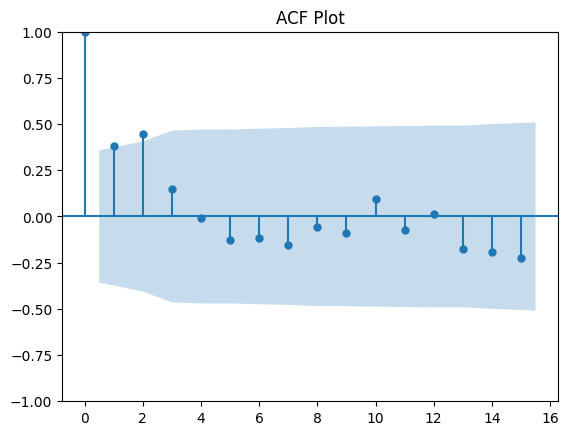

In [ ]:
plot_acf_q(tienda_1)

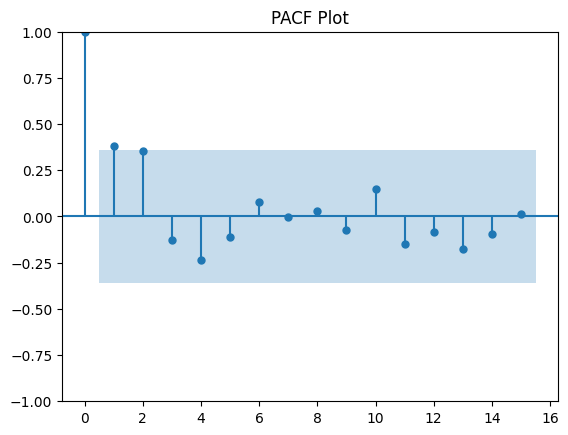

In [ ]:
plot_pacf_p(tienda_1)

In [ ]:
p,d,q = AIC(tienda_1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


    p  d  q         AIC
0   2  2  0  849.829892
1   1  2  1  850.686612
2   2  2  1  851.652366
3   1  2  2  853.076650
4   2  2  2  854.168754
5   1  2  0  856.359447
6   0  2  2  856.676978
7   0  2  1  862.927842
8   0  1  2  872.314062
9   1  1  2  873.934860
10  2  1  2  875.209168
11  1  1  0  875.379243
12  2  1  0  876.620032
13  1  1  1  877.021909
14  2  1  1  878.031285
15  0  1  1  879.092192
16  0  1  0  882.981387
17  0  2  0  884.446379
18  1  0  2  901.274609
19  2  0  2  902.806661
20  0  0  2  903.789202
21  2  0  0  905.099866
22  2  0  1  906.743504
23  1  0  0  907.414323
24  1  0  1  907.925780
25  0  0  1  909.939510
26  0  0  0  983.531000


                               SARIMAX Results                                
Dep. Variable:            monto_total   No. Observations:                   30
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -421.915
Date:                Tue, 15 Oct 2024   AIC                            849.830
Time:                        06:50:00   BIC                            853.827
Sample:                             0   HQIC                           851.052
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2442      0.174     -7.167      0.000      -1.584      -0.904
ar.L2         -0.5271      0.172     -3.065      0.002      -0.864      -0.190
sigma2       7.63e+11   6.46e-14   1.18e+25      0.0

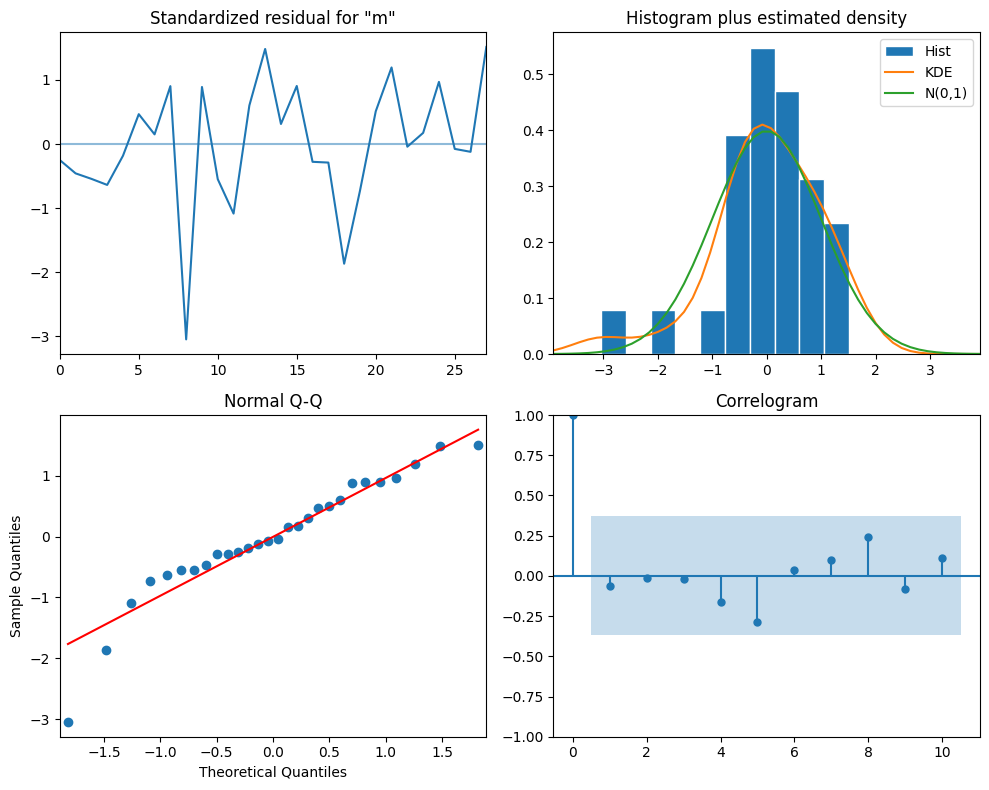

In [ ]:
arima_per_store(tienda_1['monto_total'],p,d,q)

# Tienda 2

In [ ]:
tienda_2 = final_df[final_df['tienda']=='Tienda 2']

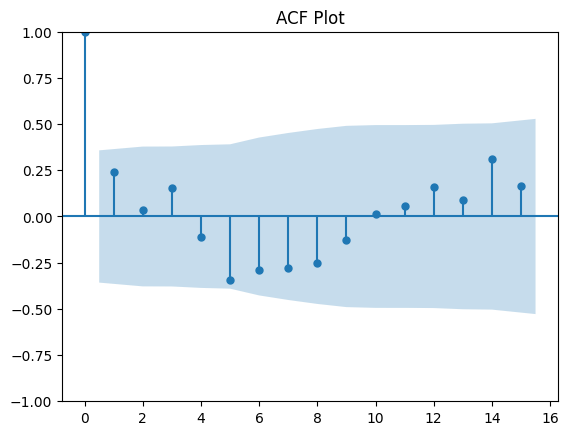

In [ ]:
plot_acf_q(tienda_2)

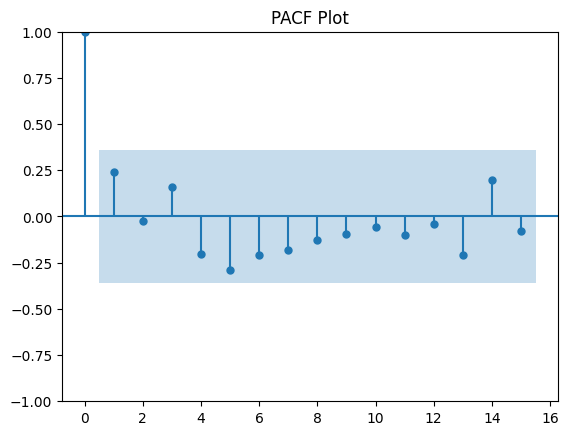

In [ ]:
plot_pacf_p(tienda_2)

In [ ]:
p2,d2,q2 = AIC(tienda_2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

    p  d  q         AIC
0   2  2  1  774.580887
1   2  2  2  776.957323
2   1  2  1  777.257733
3   0  2  2  777.538920
4   0  2  1  777.856723
5   1  2  2  779.530406
6   2  2  0  780.295726
7   1  2  0  792.169456
8   2  1  0  794.528503
9   0  1  1  794.748822
10  1  1  1  795.844348
11  0  1  2  796.441766
12  2  1  1  796.574613
13  2  1  2  796.644461
14  1  1  0  797.180256
15  1  1  2  798.390844
16  0  1  0  799.065913
17  0  2  0  800.444629
18  0  0  1  816.045889
19  1  0  0  816.094324
20  1  0  1  817.887440
21  1  0  2  818.043507
22  2  0  0  818.087470
23  0  0  2  818.099934
24  2  0  1  819.759636
25  2  0  2  821.595567
26  0  0  0  888.970679


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            monto_total   No. Observations:                   30
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -383.290
Date:                Tue, 15 Oct 2024   AIC                            774.581
Time:                        07:40:15   BIC                            779.910
Sample:                             0   HQIC                           776.210
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5063      0.203     -2.490      0.013      -0.905      -0.108
ar.L2         -0.4029      0.241     -1.673      0.094      -0.875       0.069
ma.L1         -0.8976      0.312     -2.875      0.0

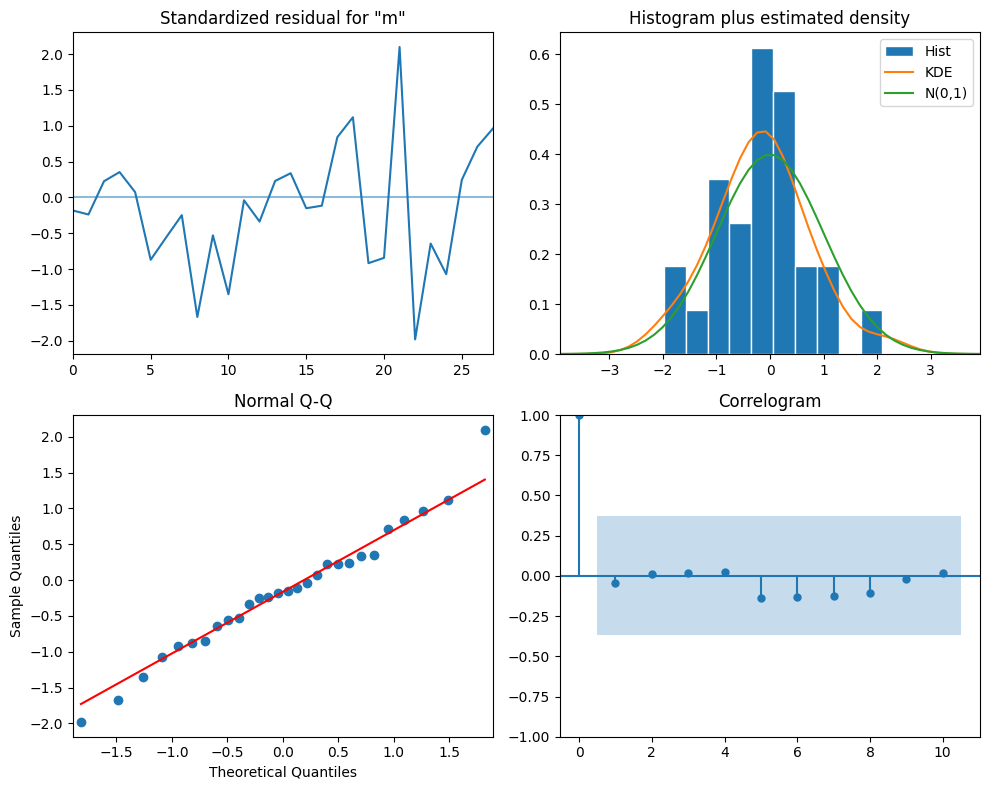

In [ ]:
arima_per_store(tienda_2['monto_total'],p2,d2,q2)

## ``Triple Exponential Smoothing``


### Functions

In [ ]:
def Exponential_Smoothing(tienda):
    model = ExponentialSmoothing(tienda['monto_total'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=12)  # Cambia a 4 si los datos son trimestrales
    model_fit = model.fit()
    # Mostrar el resumen del modelo
    print(model_fit.summary())
    return model_fit

In [ ]:
def plot_predictions(model_fit,tienda):
    tienda = tienda.set_index(['fecha'])
    predictions = model_fit.forecast(steps=6)

    last_date = tienda.index[-1]
    pred_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(months=1), periods=6, freq='MS')
    string_index = pd.Index(pred_dates.strftime('%Y-%m-%d'))

    plt.figure(figsize=(10, 6))
    plt.plot(tienda.index, tienda['monto_total'], label='Datos Observados', marker='o')
    plt.plot(string_index, predictions, label='Predicciones', marker='o', color='red')
    plt.xlim([tienda.index.min(), pred_dates.max().strftime('%Y-%m-%d')])

    all_dates = pd.date_range(start=tienda.index.min(), end=pred_dates.max().strftime('%Y-%m-%d'), freq='MS').strftime('%Y-%m-%d')
    half_xticks = all_dates[::2]
    plt.xticks(half_xticks, rotation=60)
    plt.title('Triple Exponential Smoothing - Holt-Winters para Tienda 1')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Total')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [ ]:
def MAPE(model_fit,tienda):
    # Descomposición de componentes
    fitted_values = model_fit.fittedvalues
    trend = fitted_values - (tienda['monto_total'] - fitted_values)  # Componentes de tendencia

    # Calcular la estacionalidad
    seasonal = fitted_values - trend
    irregular = tienda['monto_total'] - fitted_values

    # Calcular MAPE
    mape = calculate_mape(tienda['monto_total'], fitted_values)
    print(f'MAPE: {mape:.2f}%')

    # Graficar componentes
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(tienda.index, trend, label='Tendencia', color='blue')
    plt.title('Tendencia')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(tienda.index, seasonal, label='Estacionalidad', color='green')
    plt.title('Estacionalidad')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(tienda.index, irregular, label='Componente Irregular', color='orange')
    plt.title('Componente Irregular')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(tienda.index, tienda['monto_total'], label='Datos Observados', marker='o')
    plt.plot(tienda.index, fitted_values, label='Ajuste', marker='o', color='red')
    plt.title('Datos Observados y Ajuste')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Tienda 1

In [ ]:
tienda_1 = final_df[final_df['tienda']=='Tienda 1']

In [ ]:
model_fit = Exponential_Smoothing(tienda_1)

                       ExponentialSmoothing Model Results                       
Dep. Variable:              monto_total   No. Observations:                   30
Model:             ExponentialSmoothing   SSE                 15757097209204.422
Optimized:                         True   AIC                            841.613
Trend:                         Additive   BIC                            864.033
Seasonal:                      Additive   AICC                           903.795
Seasonal Periods:                    12   Date:                 Tue, 15 Oct 2024
Box-Cox:                          False   Time:                         06:58:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 True
smoothing_trend          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


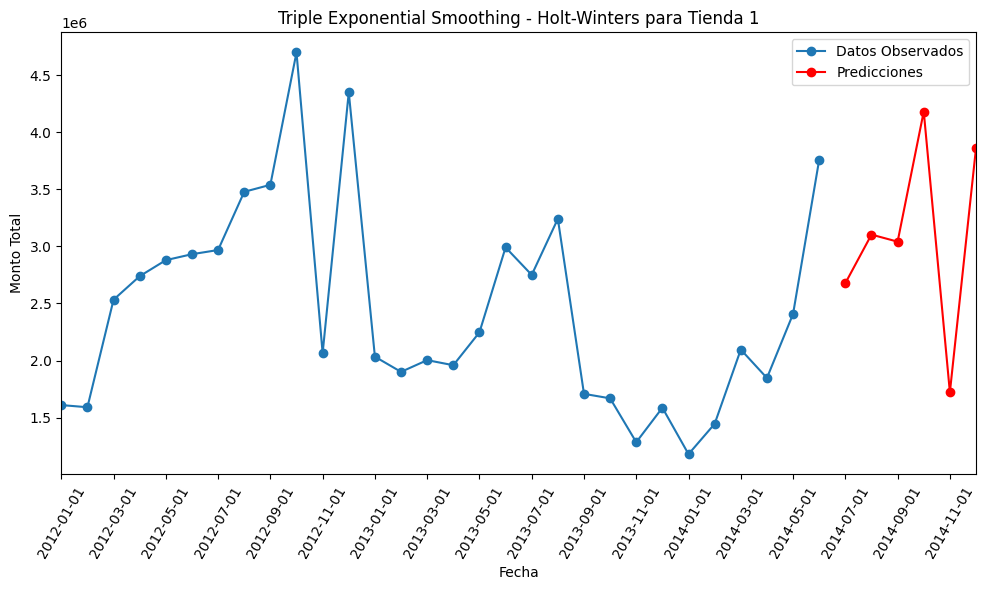

In [ ]:
plot_predictions(model_fit,tienda_1)

MAPE: 28.37%


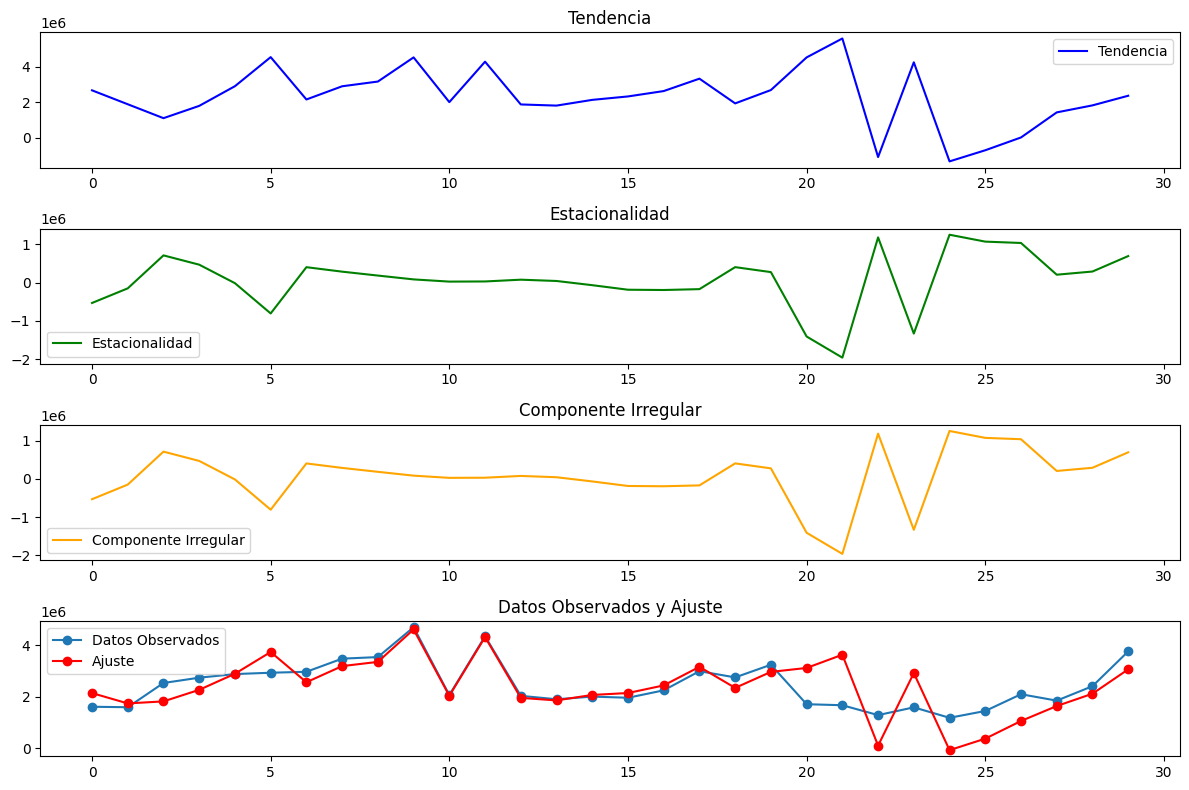

In [ ]:
MAPE(model_fit,tienda_1)

# Tienda 2

In [ ]:
tienda_2 = final_df[final_df['tienda']=='Tienda 2']

In [ ]:
model_fit2 = Exponential_Smoothing(tienda_2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:              monto_total   No. Observations:                   30
Model:             ExponentialSmoothing   SSE                   846234987664.042
Optimized:                         True   AIC                            753.886
Trend:                         Additive   BIC                            776.305
Seasonal:                      Additive   AICC                           816.068
Seasonal Periods:                    12   Date:                 Tue, 15 Oct 2024
Box-Cox:                          False   Time:                         08:18:49
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1110714                alpha                 True
smoothing_trend          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


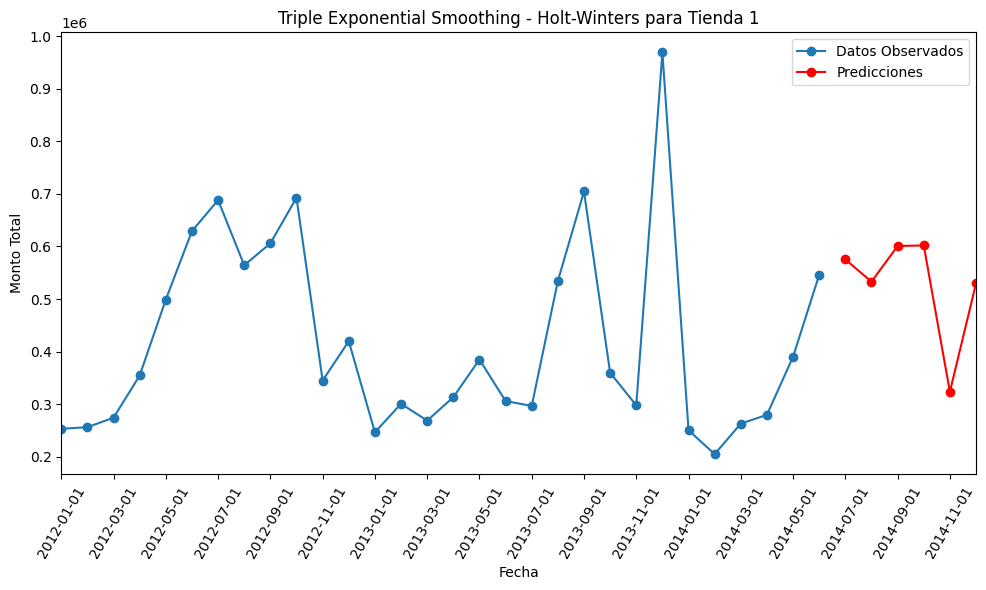

In [ ]:
plot_predictions(model_fit2,tienda_2)

MAPE: 21.78%


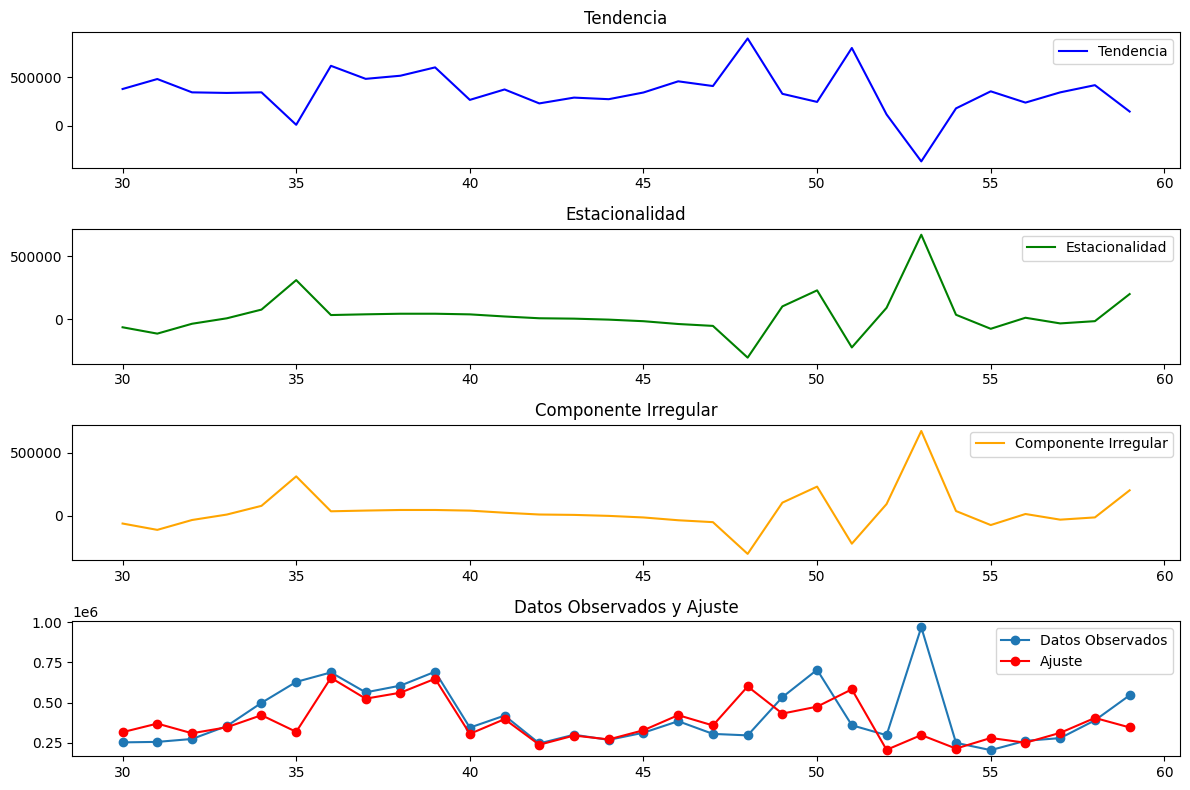

In [ ]:
MAPE(model_fit2,tienda_2)

# Evaluación de resultados

# Resultados

Las graficas muestran un comportamiento adecuado a lo que necesitamos para nuestro modelo al ajustarse  y mostranos el comportamiendo de nuestro datos en cuestión de estacinalidad, tendencias y componente irregular para Triple Exponential Smotthing, así como al correlación y correlación parcial para los valores de q y p de ARIMA, mostrando en el caso de ARIMA la realción con las observaciones pasadas y los errores pasados (residuos) para corregir posibles tendencias y en cambio Triple Exponential Smotthing que nos permite ver por separado los componentes que deseamos de tendencia, estacionalidad o componentes de nivel

# Conclusiones

Las ventas en la Tienda 1 se veran afectas por un posible declibe según las predicciones pero no tardara en recuperse según la estimación, ademas no se muestra una tendencia perpetua, por lo tanto se modifica la cantidad de ingresos durante un tiempo.